<a href="https://colab.research.google.com/github/gabrielcerono/GlioblastomaMultiforme/blob/main/Lammer2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The paper is found here: https://doi.org/10.1371/journal.pone.0221502https://doi.org/10.1371/journal.pone.0221502


The original dataset here: https://figshare.com/articles/dataset/Clinical_data_of_individual_patients_/14201600

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [2]:
dataset = pd.read_csv('/content/glioblastomadataset.csv')

In [3]:
dataset.head()

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
0,0,50,1,0,0,0,4.6
1,0,60,1,0,0,0,0.7
2,0,53,1,0,0,1,11.3
3,0,43,1,0,0,1,10.3
4,0,65,1,1,0,0,7.9


In [4]:
dataset.describe()

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.583333,56.983333,0.916667,0.383333,0.633333,0.400000,15.713333
std,0.497167,12.085138,0.278718,0.490301,0.485961,0.494032,11.745962
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.700000
25%,0.000000,50.750000,1.000000,0.000000,0.000000,0.000000,8.925000
50%,1.000000,58.000000,1.000000,0.000000,1.000000,0.000000,12.500000
75%,1.000000,65.250000,1.000000,1.000000,1.000000,1.000000,21.300000
max,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,52.400000


# First, we should make a quick data exploratory analysis.

In [ ]:
import seaborn as sns

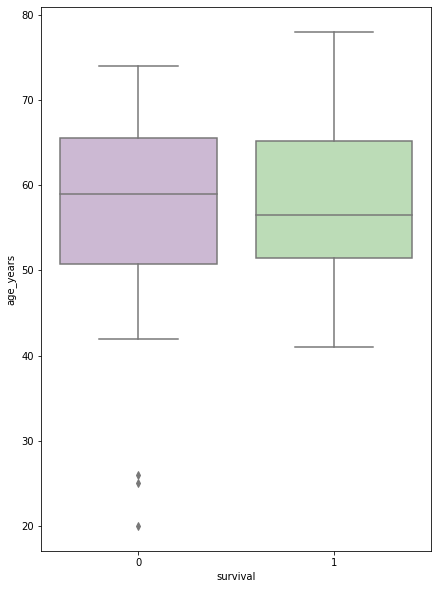

In [ ]:
f,ax = plt.subplots(figsize =(7,10))
sns.boxplot(x="survival", y = 'age_years', data=dataset, palette="PRGn",ax=ax)
plt.show()

(0.0, 1.0)

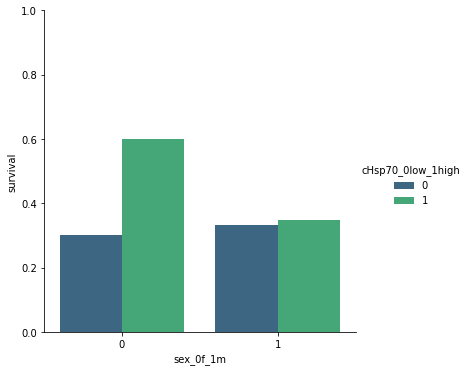

In [ ]:
sns.catplot(x="sex_0f_1m", y="survival", hue="cHsp70_0low_1high", ci=None, palette='viridis', kind="bar", data=dataset)
plt.ylim(0, 1)

It seems that high levels cHsp70 increase survival rate only in females, something the original paper did not mention. We would have to look for covariates, and see if sex actually impact un survivality.

(0.0, 1.0)

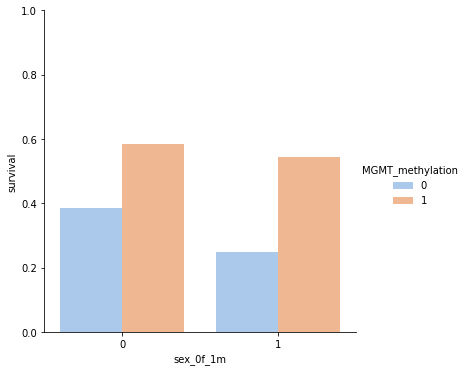

In [ ]:
sns.catplot(x="sex_0f_1m", y="survival", hue="MGMT_methylation", kind="bar", palette="pastel", ci=None, data=dataset)
plt.ylim(0, 1)

(0.0, 1.0)

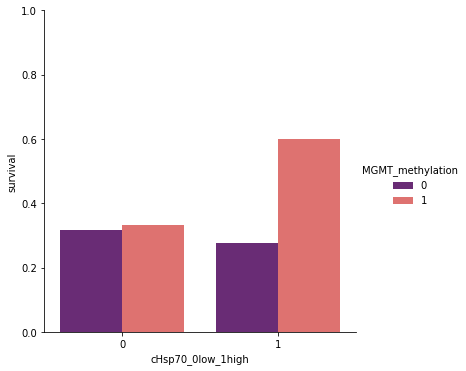

In [ ]:
sns.catplot(x="cHsp70_0low_1high", y="survival", hue="MGMT_methylation", kind="bar", ci=None,  palette="magma", data=dataset)
plt.ylim(0, 1)

It seems like MGMT methylation has a permissive effect on ChSp. The original paper did arrived to this conclusion. 

(0.0, 1.2)

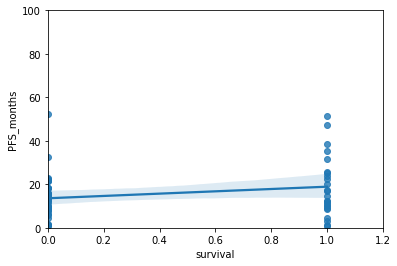

In [ ]:
sns.regplot(x="survival", y="PFS_months", data=dataset)
plt.ylim(0, 100)
plt.xlim(0, 1.2)

In [ ]:
dataset.corr(method='pearson')

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
sex_0f_1m,1.000000,-0.269165,-0.010193,-0.168035,0.058461,-0.138013,0.039569
age_years,-0.269165,1.000000,-0.161440,0.118375,0.079750,0.080623,0.177742
did_progress,-0.010193,-0.161440,1.000000,-0.010336,-0.229416,-0.369274,-0.456801
MGMT_methylation,-0.168035,0.118375,-0.010336,1.000000,0.386500,0.265897,0.320183
cHsp70_0low_1high,0.058461,0.079750,-0.229416,0.386500,1.000000,0.127076,0.328388
survival,-0.138013,0.080623,-0.369274,0.265897,0.127076,1.000000,0.223676
PFS_months,0.039569,0.177742,-0.456801,0.320183,0.328388,0.223676,1.000000


# First analysis


First we want to divide the dataset in 3 sections:

1.   Train set
2.   Ranking feature set
3.   Test



In [5]:
X = dataset.drop(columns=['survival', 'PFS_months'], axis = 1)
y = dataset['survival']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [8]:
clf = RandomForestClassifier(random_state=0)


### Random Forest


In [54]:
mttavg= []
favg= []
accuracyavg = []
tpavg = []
tnavg = []
rocavg = []
praucavg = []




for x in range(1000): 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  clf.fit(X_train, y_train)
  #That's for the ranking, now we gotta do for the validation set and also for all the metrics
  mttaverage = matthews_corrcoef(y_test, clf.predict(X_test))
  mttavg.append(mttaverage)
   #f1 score
  faverage = f1_score(y_test, clf.predict(X_test))
  favg.append(faverage)
  #accuracy score
  accuracyaverage = accuracy_score(y_test, clf.predict(X_test))
  accuracyavg.append(accuracyaverage)
  #TP and TN rate 
  tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test), labels =[0,1]).ravel()
  tprate =  tp / (tp + fn)
  tnrate = tn / (tn + fp)
  tpavg.append(tprate)
  tnavg.append(tnrate)
  # ROC AUC 
  roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
  rocavg.append(roc)
  #Precision recall area under de curve
  precision, recall, _thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
  prauc = metrics.auc(recall, precision)     
  praucavg.append(prauc)


mttavgmean = np.mean(np.array(mttavg))
favgmean = np.mean(np.array(favg))
accuracyavgmean = np.mean(np.array(accuracyavg))
tpavgmean = np.mean(np.array(tpavg))
tnavgmean = np.mean(np.array(tnavg))
rocavgmean = np.mean(np.array(rocavg))
praucavgmean = np.mean(np.array(praucavg))
metricss = np.array([mttavgmean, favgmean, accuracyavgmean, tpavgmean, tnavgmean, rocavgmean, praucavgmean])
metricss = metricss.reshape(1,7)
metric_final = pd.DataFrame(data = metricss, columns = ['matthewscore', 'f1-score', 'Accuracy', 'True Positives', 'True Negatives', 'ROC AUC', 'PR AUC'])

In [55]:
metric_final

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,0.054428,0.401981,0.538667,0.412898,0.638916,0.527387,0.502902


### XgBoost


In [42]:
xgb = xgb.XGBClassifier(random_state=42)

In [43]:
mttavg= []
favg= []
accuracyavg = []
tpavg = []
tnavg = []
rocavg = []
praucavg = []




for x in range(100): 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  xgb.fit(X_train, y_train)
  #That's for the ranking, now we gotta do for the validation set and also for all the metrics
  mttaverage = matthews_corrcoef(y_test,xgb.predict(X_test))
  mttavg.append(mttaverage)
   #f1 score
  faverage = f1_score(y_test,xgb.predict(X_test))
  favg.append(faverage)
  #accuracy score
  accuracyaverage = accuracy_score(y_test,xgb.predict(X_test))
  accuracyavg.append(accuracyaverage)
  #TP and TN rate 
  tn, fp, fn, tp = confusion_matrix(y_test,xgb.predict(X_test), labels =[0,1]).ravel()
  tprate =  tp / (tp + fn)
  tnrate = tn / (tn + fp)
  tpavg.append(tprate)
  tnavg.append(tnrate)
  # ROC AUC 
  roc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
  rocavg.append(roc)
  #Precision recall area under de curve
  precision, recall, _thresholds = metrics.precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
  prauc = metrics.auc(recall, precision)     
  praucavg.append(prauc)

  
mttavgmean = np.mean(np.array(mttavg))
favgmean = np.mean(np.array(favg))
accuracyavgmean = np.mean(np.array(accuracyavg))
tpavgmean = np.mean(np.array(tpavg))
tnavgmean = np.mean(np.array(tnavg))
rocavgmean = np.mean(np.array(rocavg))
praucavgmean = np.mean(np.array(praucavg))
metricss = np.array([mttavgmean, favgmean, accuracyavgmean, tpavgmean, tnavgmean, rocavgmean, praucavgmean])
metricss = metricss.reshape(1,7)
metric_final = pd.DataFrame(data = metricss, columns = ['matthewscore', 'f1-score', 'Accuracy', 'True Positive rate', 'True Negative rate', 'ROC AUC', 'PR AUC'])
  

In [44]:
metric_final

,matthewscore,f1-score,Accuracy,True Positive rate,True Negative rate,ROC AUC,PR AUC
0,-0.092096,0.302978,0.469444,0.317406,0.594664,0.439971,0.394307


### KNN 

In [18]:
knn = KNeighborsClassifier()

In [35]:
mttavg= []
favg= []
accuracyavg = []
tpavg = []
tnavg = []
rocavg = []
praucavg = []




for x in range(100): 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  knn.fit(X_train, y_train)
  #That's for the ranking, now we gotta do for the validation set and also for all the metrics
  mttaverage = matthews_corrcoef(y_test,knn.predict(X_test))
  mttavg.append(mttaverage)
   #f1 score
  faverage = f1_score(y_test,knn.predict(X_test))
  favg.append(faverage)
  #accuracy score
  accuracyaverage = accuracy_score(y_test,knn.predict(X_test))
  accuracyavg.append(accuracyaverage)
  #TP and TN rate 
  tn, fp, fn, tp = confusion_matrix(y_test,knn.predict(X_test), labels =[0,1]).ravel()
  tprate =  tp / (tp + fn)
  tnrate = tn / (tn + fp)
  tpavg.append(tprate)
  tnavg.append(tnrate)
  # ROC AUC 
  roc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
  rocavg.append(roc)
  #Precision recall area under de curve
  precision, recall, _thresholds = metrics.precision_recall_curve(y_test, knn.predict_proba(X_test)[:, 1])
  prauc = metrics.auc(recall, precision)     
  praucavg.append(prauc)

mttavgmean = np.mean(np.array(mttavg))
favgmean = np.mean(np.array(favg))
accuracyavgmean = np.mean(np.array(accuracyavg))
tpavgmean = np.mean(np.array(tpavg))
tnavgmean = np.mean(np.array(tnavg))
rocavgmean = np.mean(np.array(rocavg))
praucavgmean = np.mean(np.array(praucavg))
metricss = np.array([mttavgmean, favgmean, accuracyavgmean, tpavgmean, tnavgmean, rocavgmean, praucavgmean])
metricss = metricss.reshape(1,7)
knn_metric_final = pd.DataFrame(data = metricss, columns = ['matthewscore', 'f1-score', 'Accuracy', 'True Positive rate', 'True Negative rate', 'ROC AUC', 'PR AUC'])

In [36]:
knn_metric_final

,matthewscore,f1-score,Accuracy,True Positive rate,True Negative rate,ROC AUC,PR AUC
0,-0.011975,0.31403,0.518333,0.303689,0.680199,0.475743,0.445979


### Logistic Regression

In [56]:
log = LogisticRegression(random_state=42)

In [57]:
mttavg= []
favg= []
accuracyavg = []
tpavg = []
tnavg = []
rocavg = []
praucavg = []



for x in range(1000): 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  log.fit(X_train, y_train)
  #That's for the ranking, now we gotta do for the validation set and also for all the metrics
  mttaverage = matthews_corrcoef(y_test,log.predict(X_test))
  mttavg.append(mttaverage)
   #f1 score
  faverage = f1_score(y_test,log.predict(X_test))
  favg.append(faverage)
  #accuracy score
  accuracyaverage = accuracy_score(y_test,log.predict(X_test))
  accuracyavg.append(accuracyaverage)
  #TP and TN rate 
  tn, fp, fn, tp = confusion_matrix(y_test,log.predict(X_test), labels =[0,1]).ravel()
  tprate =  tp / (tp + fn)
  tnrate = tn / (tn + fp)
  tpavg.append(tprate)
  tnavg.append(tnrate)
  # ROC AUC 
  roc = roc_auc_score(y_test, log.predict_proba(X_test)[:, 1])
  rocavg.append(roc)
  #Precision recall area under de curve
  precision, recall, _thresholds = metrics.precision_recall_curve(y_test, log.predict_proba(X_test)[:, 1])
  prauc = metrics.auc(recall, precision)     
  praucavg.append(prauc)


mttavgmean = np.mean(np.array(mttavg))
favgmean = np.mean(np.array(favg))
accuracyavgmean = np.mean(np.array(accuracyavg))
tpavgmean = np.mean(np.array(tpavg))
tnavgmean = np.mean(np.array(tnavg))
rocavgmean = np.mean(np.array(rocavg))
praucavgmean = np.mean(np.array(praucavg))
metricss = np.array([mttavgmean, favgmean, accuracyavgmean, tpavgmean, tnavgmean, rocavgmean, praucavgmean])
metricss = metricss.reshape(1,7)

log_metric_final = pd.DataFrame(data = metricss, columns = ['matthewscore', 'f1-score', 'Accuracy', 'True Positive rate', 'True Negative rate', 'ROC AUC', 'PR AUC'])

In [58]:
log_metric_final

,matthewscore,f1-score,Accuracy,True Positive rate,True Negative rate,ROC AUC,PR AUC
0,0.180882,0.376844,0.604389,0.338208,0.815599,0.628874,0.576559


## RFE with Matthew score as ranking system - Without Pogression free time 

In [59]:
import RFE_Glioblastoma as rfe

In [61]:
ranking = rfe.RankingRE(X, y, 10, clf)

In [62]:
rank, metrics = ranking.ranking_by_matthew_punishment()

In [63]:
rank

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
2,did_progress,0.047571952335789695,1.0,0.20615550676021166
0,sex_0f_1m,0.02860497476409742,2.0,0.24639584060075306
1,age_years,0.016156478110004195,3.0,0.13347473666618506
3,MGMT_methylation,0.014631866054911399,4.0,0.1687434721942651
4,cHsp70_0low_1high,-0.03165726663314493,5.0,0.23830862392002045


In [80]:
top_features = rank.iloc[[0,1],[0]].to_numpy()
top_features

array([['did_progress'],
       ['sex_0f_1m']], dtype=object)

In [91]:
X_top = X[top_features.reshape(2)]

In [ ]:
X_top

In [93]:
randseed = np.random.randint(9999, size = 1500)

In [108]:
randseed

array([1499, 2955, 4326, ..., 8041, 9197, 8606])

In [117]:
randseed[ass]

3281

In [101]:
ass = 0


In [116]:
ass += 1

In [105]:
ass

3

In [ ]:
metrics

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,0.118034,0.396463,0.5805,0.412111,0.70366,0.556744,0.493785


## [XgBoost] -RFE

In [ ]:
import xgboost as xgb


In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)

In [ ]:
ranking_xgb = rfe.RankingRE(X, y, 100, xgb_model)

In [ ]:
rank_xgb, metrics_xgb = ranking_xgb.ranking_by_matthew_punishment()

In [ ]:
rank_xgb

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
3,MGMT_methylation,0.024558382406383094,1.0,0.16119283812669075
2,did_progress,0.0006546540440286216,2.0,0.006513725494595207
1,age_years,-0.09136617246844875,3.0,0.22589242931684492
0,sex_0f_1m,-0.015332535877537311,4.0,0.15621016087089828
4,cHsp70_0low_1high,-0.009570804858977149,5.0,0.1284199119523707


In [ ]:
 metrics_xgb 

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,-0.008832,0.321847,0.5165,0.341075,0.650153,0.506469,0.447482


## Logistic Regression - RFE


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_regressor = LogisticRegression(random_state=42)

In [ ]:
ranking_lgr = rfe.RankingRE(X, y, 100, log_regressor)

In [ ]:
rank_lgr, metrics_lgr = ranking_lgr.ranking_by_matthew_punishment()

In [ ]:
rank_lgr

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
2,did_progress,0.06402542313015255,1.0,0.13948621865752894
3,MGMT_methylation,0.04763654067297669,2.0,0.16548833014266537
1,age_years,-0.061350892408696824,3.0,0.18870687229184
0,sex_0f_1m,-0.02843423006622815,4.0,0.14966363033301205
4,cHsp70_0low_1high,-0.01176847552435224,5.0,0.12921303240488743


In [ ]:
metrics_lgr

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,0.095865,0.306615,0.562,0.300001,0.773156,0.556414,0.512744


## Decision Trees - RFE

In [7]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(random_state=42)

In [8]:
ranking_dct = rfe.RankingRE(X, y, 100, dec_tree)

NameError: ignored

In [ ]:
rank_dct, metrics_dct = ranking_dct.ranking_by_matthew_punishment()

In [ ]:
rank_dct

In [ ]:
metrics_dct

## K-Nearest Neightbors - RFE

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [ ]:
ranking_knn = rfe.RankingRE(X, y, 100, knn)

In [ ]:
rank_knn, metrics_knn = ranking_knn.ranking_by_matthew_punishment()

In [ ]:
rank_knn

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
2,did_progress,0.004683616483192665,1.0,0.044126478443801305
3,MGMT_methylation,0.0038386279957425573,2.0,0.047091790625171874
1,age_years,-0.14730433180517744,3.0,0.3071626478540861
0,sex_0f_1m,-0.010051504658167646,4.0,0.07205418778046549
4,cHsp70_0low_1high,-0.004283943007981022,5.0,0.06754610842745187


In [ ]:
metrics_knn

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,-0.023987,0.254812,0.536,0.272745,0.714223,0.4953,0.466794


# top feature testing


In [10]:
import RFE_Glioblastomav2 as rfev2

In [11]:
ranking_tf = rfev2.RankingRE(X, y, 10, clf)

In [12]:
rank, metrics, metrics_tf = ranking_tf.ranking_by_matthew_punishment()

In [13]:
rank

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
3,MGMT_methylation,0.09161756413790567,1.0,0.13329668650895937
4,cHsp70_0low_1high,-0.1003503032243442,2.0,0.19709174066828317
1,age_years,-0.049729366888675894,3.0,0.23876559273004244
2,did_progress,-0.035592478611625955,4.0,0.12668720793160623
0,sex_0f_1m,-0.01457836843658521,5.0,0.21979554648280036


In [14]:
metrics

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,0.084133,0.385895,0.565,0.386959,0.692258,0.51769,0.447335


In [15]:
metrics_tf

,matthewscore,f1-score,Accuracy,True Positives,True Negatives,ROC AUC,PR AUC
0,0.061458,0.286642,0.55,0.352381,0.712729,0.601886,0.597666
